In [269]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Input, Concatenate
import tensorflow_hub as hub

In [300]:
# Data preprocessing
# train_df = pd.read_csv("train_spotify_datasetNew.csv")
train_df = pd.read_csv("train_spotify_dataset.csv")
val_df = pd.read_csv("val_spotify_dataset.csv")
test_df = pd.read_csv("test_spotify_dataset.csv")

# Remove rows with missing Spotify audio data
train_df.dropna(subset=['emotion_4Q', 'tempo', 'energy', 'loudness', 'danceability', 'liveness', 'mode', 'speechiness', 'valence'], inplace=True)
val_df.dropna(subset=['emotion_4Q', 'tempo', 'energy', 'loudness', 'danceability', 'liveness', 'mode', 'speechiness', 'valence'], inplace=True)
test_df.dropna(subset=['emotion_4Q', 'tempo', 'energy', 'loudness', 'danceability', 'liveness', 'mode', 'speechiness', 'valence'], inplace=True)

# Separate features and labels
X_train_text = train_df['lyrics'].values
X_val_text = val_df['lyrics'].values
X_test_text = test_df['lyrics'].values

# Standardize numerical features
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(train_df[['tempo', 'energy', 'loudness', 'danceability', 'liveness', 'mode', 'speechiness', 'valence']].values)
X_val_numerical_scaled = scaler.transform(val_df[['tempo', 'energy', 'loudness', 'danceability', 'liveness', 'mode', 'speechiness', 'valence']].values)
X_test_numerical_scaled = scaler.transform(test_df[['tempo', 'energy', 'loudness', 'danceability', 'liveness', 'mode', 'speechiness', 'valence']].values)

# Convert emotion labels to one-hot encoding
train_labels = pd.get_dummies(train_df['emotion_4Q'])
val_labels = pd.get_dummies(val_df['emotion_4Q'])
test_labels = pd.get_dummies(test_df['emotion_4Q'])

In [301]:
# Lyrics Cleaning
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove text within square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove non-alphanumeric characters and extra whitespaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    # # Remove stopwords
    # text = ' '.join([word for word in text.split() if word not in stop_words])
    return text.strip()

# Apply the cleaning function to each lyric in the dataset
train_df['clean_lyrics'] = train_df['lyrics'].apply(clean_text)
val_df['clean_lyrics'] = val_df['lyrics'].apply(clean_text)
test_df['clean_lyrics'] = test_df['lyrics'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Print a few lines of cleaned lyrics data
for i in range(5):
    print(train_df['clean_lyrics'][i])
    print('-' * 50)

In [283]:
# Load Universal Sentence Encoder
use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [303]:
# Convert lyrics to embeddings
X_train_text = use_embed(train_df['clean_lyrics'].values)
X_val_text = use_embed(val_df['clean_lyrics'].values)
X_test_text = use_embed(test_df['clean_lyrics'].values)

Model Design

We can add
- dense layers: You could add more dense layers with different numbers of units and activation functions to increase the model's capacity to learn complex patterns in the data.
- dropout layer: Adding dropout regularization can help prevent overfitting by randomly setting a fraction of input units to zero during training. You can add a dropout layer after the dense layer.
- Batch Normalization: Batch normalization can help stabilize and accelerate the training process by normalizing the activations of the previous layer. It can be added before or after the activation function
- Regularization: You can add L2 regularization to the dense layers to penalize large weights and prevent overfitting.

In [285]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Reshape

In [308]:
# Define model architecture 1
text_input = Input(shape=(X_train_text.shape[1],))
# embedded_text = embedding_layer(text_input) # remove if not using GloVe
numerical_input = Input(shape=(X_train_numerical_scaled.shape[1],))

# text_input = Input(shape=(512,))
# numerical_input = Input(shape=(8,))  # Assuming 8 numerical features

# Concatenate pooled layer with numerical input
concatenated = Concatenate()([text_input, numerical_input])

# concatenated = Concatenate()([text_input, numerical_input])
dense_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(concatenated)

# Add dropout regularization
dropout_rate = 0.3  # Adjust as needed
dropout_layer = Dropout(dropout_rate)(dense_layer)

output_layer = Dense(4, activation='softmax')(dropout_layer)  # Assuming 4 emotion classes

# Define model
model = tf.keras.Model(inputs=[text_input, numerical_input], outputs=output_layer)

In [309]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit([X_train_text, X_train_numerical_scaled], train_labels,
                    validation_data=([X_val_text, X_val_numerical_scaled], val_labels),
                    epochs=15, batch_size=64)

Epoch 1/15
20/20 [==============================] - 1s 14ms/step - loss: 1.2844 - accuracy: 0.4523 - val_loss: 1.1598 - val_accuracy: 0.5957
Epoch 2/15
20/20 [==============================] - 0s 4ms/step - loss: 1.0912 - accuracy: 0.5898 - val_loss: 0.9969 - val_accuracy: 0.6462
Epoch 3/15
20/20 [==============================] - 0s 6ms/step - loss: 0.9613 - accuracy: 0.6430 - val_loss: 0.8896 - val_accuracy: 0.6498
Epoch 4/15
20/20 [==============================] - 0s 4ms/step - loss: 0.8775 - accuracy: 0.6617 - val_loss: 0.8294 - val_accuracy: 0.6606
Epoch 5/15
20/20 [==============================] - 0s 5ms/step - loss: 0.8335 - accuracy: 0.6820 - val_loss: 0.7947 - val_accuracy: 0.6751
Epoch 6/15
20/20 [==============================] - 0s 4ms/step - loss: 0.7930 - accuracy: 0.6836 - val_loss: 0.7733 - val_accuracy: 0.6715
Epoch 7/15
20/20 [==============================] - 0s 5ms/step - loss: 0.7513 - accuracy: 0.7133 - val_loss: 0.7568 - val_accuracy: 0.6715
Epoch 8/15
20/20 [=

In [310]:
loss, accuracy = model.evaluate([X_test_text, X_test_numerical_scaled], test_labels)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

9/9 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.7240
Test Loss: 0.6950209736824036, Test Accuracy: 0.7240143418312073



# Error Analysis

In [264]:
# Get the list of emotion names (column names) from the one-hot encoded labels
emotion_names = train_labels.columns.tolist()

# Create a mapping from encoded labels to emotion names
label_mapping = {i: emotion_names[i] for i in range(len(emotion_names))}

# Print the label mapping
print(label_mapping)

{0: 'angry', 1: 'happy', 2: 'relaxed', 3: 'sad'}


9/9 [==============================] - 0s 2ms/step


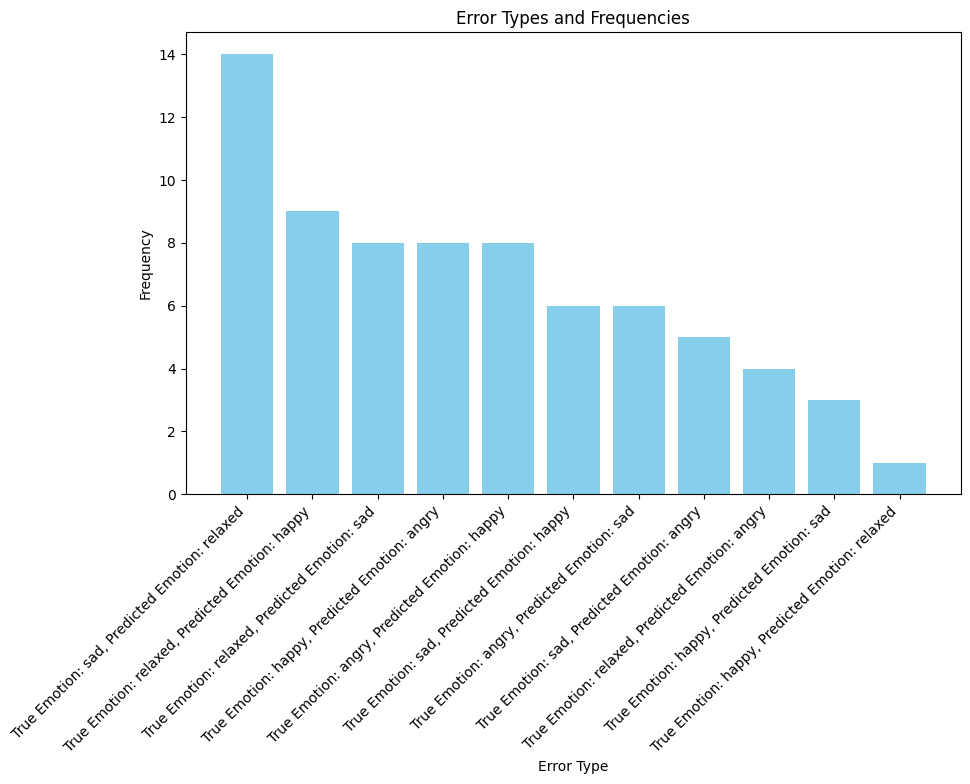

In [265]:
import matplotlib.pyplot as plt
from collections import Counter

# Generate predictions on the test data
predictions = model.predict([X_test_text, X_test_numerical_scaled])

# Convert predictions to emotion labels
predicted_emotions = [emotion_names[np.argmax(pred)] for pred in predictions]

# Get true emotions from one-hot encoded labels
true_emotions = [emotion_names[np.argmax(label)] for label in test_labels.values]

# Initialize a list to store error tuples
error_tuples = []

# Count error occurrences and create error tuples
for true_emotion, predicted_emotion in zip(true_emotions, predicted_emotions):
    if true_emotion != predicted_emotion:
        error_tuples.append((true_emotion, predicted_emotion))

# Count the occurrences of each error
error_counts = Counter(error_tuples)

# Sort error counts by frequency
sorted_error_counts = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)

# Plot the error types and frequencies
plt.figure(figsize=(10, 6))
error_types = [f'True Emotion: {true}, Predicted Emotion: {pred}' for (true, pred), _ in sorted_error_counts]
frequencies = [count for _, count in sorted_error_counts]
plt.bar(error_types, frequencies, color='skyblue')
plt.ylabel('Frequency')
plt.xlabel('Error Type')
plt.title('Error Types and Frequencies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


In [266]:
# Print out error types and frequencies
for (true_label, pred_label), count in sorted_error_counts:
    print("True Emotion:", true_label, ", Predicted Emotion:", pred_label)
    print("Count:", count)

True Emotion: sad , Predicted Emotion: relaxed
Count: 14
True Emotion: relaxed , Predicted Emotion: happy
Count: 9
True Emotion: relaxed , Predicted Emotion: sad
Count: 8
True Emotion: happy , Predicted Emotion: angry
Count: 8
True Emotion: angry , Predicted Emotion: happy
Count: 8
True Emotion: sad , Predicted Emotion: happy
Count: 6
True Emotion: angry , Predicted Emotion: sad
Count: 6
True Emotion: sad , Predicted Emotion: angry
Count: 5
True Emotion: relaxed , Predicted Emotion: angry
Count: 4
True Emotion: happy , Predicted Emotion: sad
Count: 3
True Emotion: happy , Predicted Emotion: relaxed
Count: 1


In [267]:
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_67 (InputLayer)       [(None, 512)]                0         []                            
                                                                                                  
 input_68 (InputLayer)       [(None, 8)]                  0         []                            
                                                                                                  
 concatenate_33 (Concatenat  (None, 520)                  0         ['input_67[0][0]',            
 e)                                                                  'input_68[0][0]']            
                                                                                                  
 dense_66 (Dense)            (None, 64)                   33344     ['concatenate_33[0][0]'

9/9 [==============================] - 0s 2ms/step


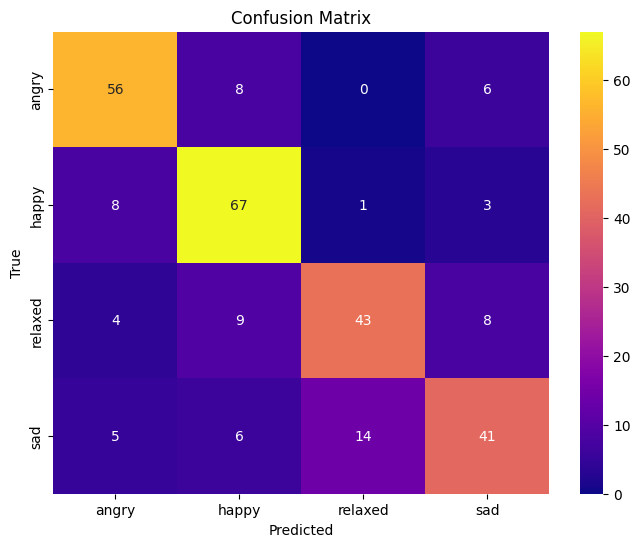

In [268]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels from DataFrame
y_true = test_labels.idxmax(axis=1)

# Get predicted labels from model predictions
y_pred_probs = model.predict([X_test_text, X_test_numerical_scaled])
y_pred = pd.DataFrame(y_pred_probs, columns=test_labels.columns).idxmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Improvement Next Steps for V3

- Try removing some audio feature params (e.g. acousticness, key)
- Try GloVe Embeddings for text instead
- Try a deep convolutional model